## Import des Librairies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import json
import matplotlib.pyplot as plt
#Ajouts du Y
import plotly.express as px
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from plotly.offline import plot
import plotly.graph_objects as go
from keras.layers import Input , Flatten , Dense, Dropout
from keras.models import Sequential , Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def pretty(d, indent=0):
   for key, value in d.items():
      print('\t' * indent + str(key))
      if isinstance(value, dict):
         pretty(value, indent+1)
      else:
         print('\t' * (indent+1) + str(value))

## Lecture du dataset et préparation des données

In [3]:
## Import des données depuis le fichier de data_spotify.csv
## Modifiez la variable suivante pour entrer le chemin vers le fichier "data_spotify.csv"

path_to_csv = "drive/MyDrive/data/data_spotify.csv"
dataset = pd.read_csv(path_to_csv, header=0)
dataset.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1.520000e+03
mean,0.570425,0.558098,5.111842,-10.711768,0.611184,0.083425,0.342754,0.160376,0.162685,0.528442,117.321020,2.644412e+05
std,0.199090,0.286859,3.614304,7.094815,0.487642,0.082916,0.363354,0.309547,0.129194,0.278685,29.524302,1.129081e+05
min,0.000000,0.001100,0.000000,-42.261000,0.000000,0.000000,0.000005,0.000000,0.018800,0.000000,0.000000,5.292900e+04
25%,0.437000,0.361000,2.000000,-13.039500,0.000000,0.037800,0.029900,0.000001,0.086700,0.296000,94.826000,2.004562e+05
50%,0.593000,0.620500,5.000000,-8.519500,1.000000,0.048900,0.168000,0.000371,0.114000,0.549000,116.109000,2.357335e+05
75%,0.728000,0.786000,8.000000,-5.766500,1.000000,0.085375,0.678250,0.093375,0.197250,0.769000,134.890750,2.964702e+05
max,0.975000,0.996000,11.000000,-0.140000,1.000000,0.513000,0.996000,0.982000,0.979000,0.982000,213.087000,1.252322e+06


In [4]:
dataset_numpy = dataset.to_numpy()
X, y = dataset_numpy[:,:-1], dataset_numpy[:,-1]

# Création de structure de données utiles
class_to_number = {x:i for i,x in enumerate(np.unique(y))}
number_to_class = {class_to_number[x]:x for x in np.unique(y)}

print(class_to_number, number_to_class)

y = np.array([class_to_number[a] for a in y])
print(X.shape, y.shape)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9} {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
(1520, 12) (1520,)


### Normalisation des données

In [5]:
sc = StandardScaler()
X = sc.fit_transform(X)


## Analyse des données

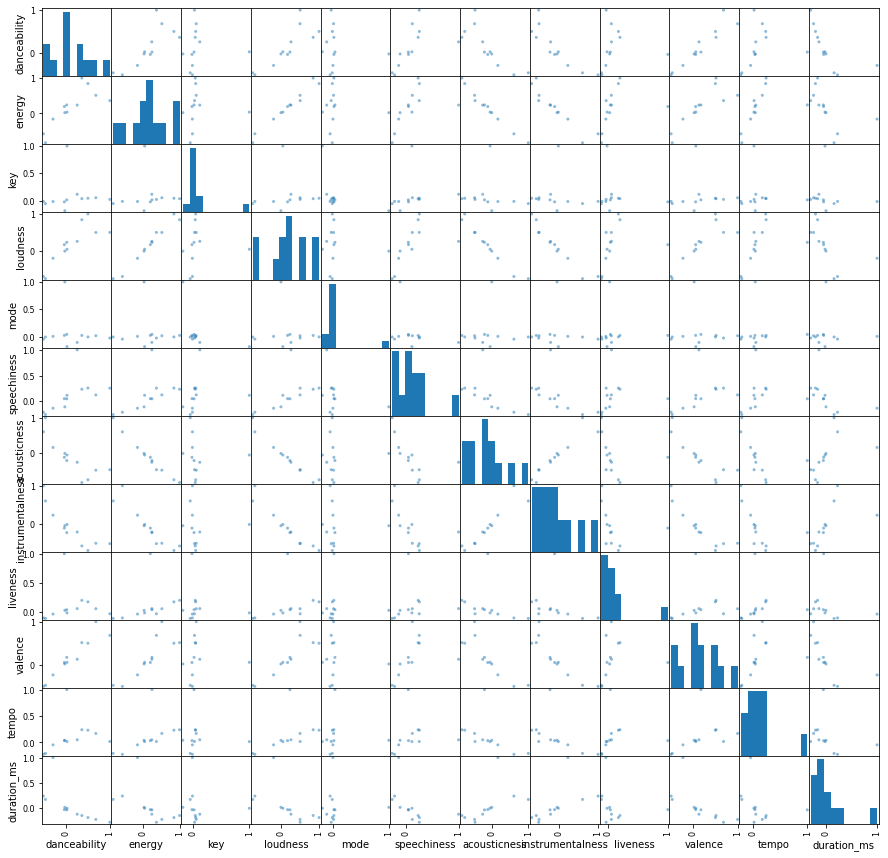

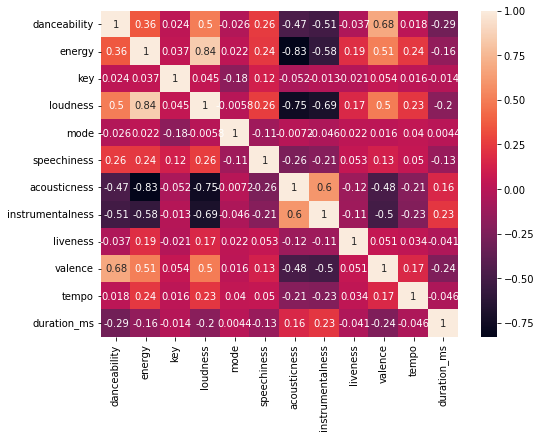

In [6]:
#Corrélation des attributs
dataset_panda = dataset.drop(columns=["genre"])
tabCorr = dataset_panda.corr()

pd.plotting.scatter_matrix(tabCorr,figsize=(15,15))


plt.figure(figsize=(8, 6))
sns.heatmap(tabCorr, annot=True)
plt.show()


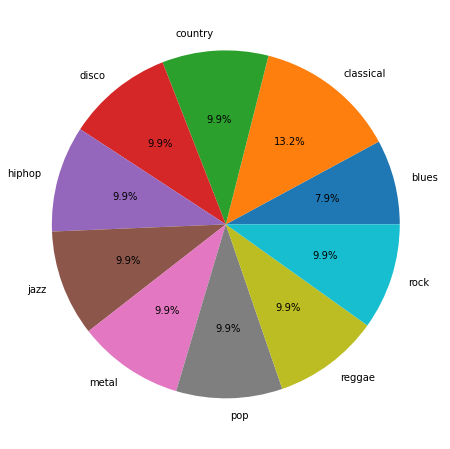

In [7]:
#Caractéristiques des classes
#Répartition
class_count = np.array([[key, np.count_nonzero(y==value),100*np.count_nonzero(y==value)/np.count_nonzero(y)] for key, value in class_to_number.items()])

plt.figure(figsize=(8,8))
plt.pie(class_count.T[1],labels = class_count.T[0],autopct='%1.1f%%')
plt.show()


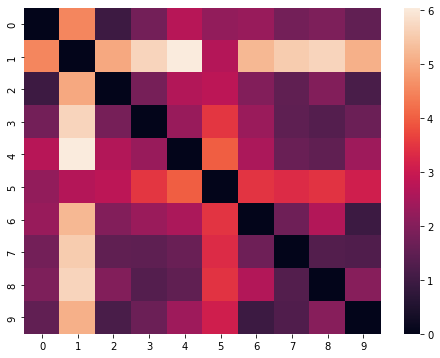

In [8]:
#Distance interclasses

classes = [[] for i in range(len(class_to_number))]
for i in range(len(X)):
    classes[y[i]].append(X[i])

#vecteurs moyens
mean_vectors = []
for i in range(len(classes)):
    mean_vectors.append(np.mean(classes[i],axis=0))

#distances entre les vecteurs moyens des classes
def dist(a,b):
    return np.linalg.norm(a-b)

distance_interclasse = np.zeros((len(class_to_number),len(class_to_number)))

for i in range(len(class_to_number)):
    for j in range(len(class_to_number)):
        distance_interclasse[i][j]= dist(mean_vectors[i],mean_vectors[j])

plt.figure(figsize=(8, 6))
sns.heatmap(distance_interclasse)
plt.show()

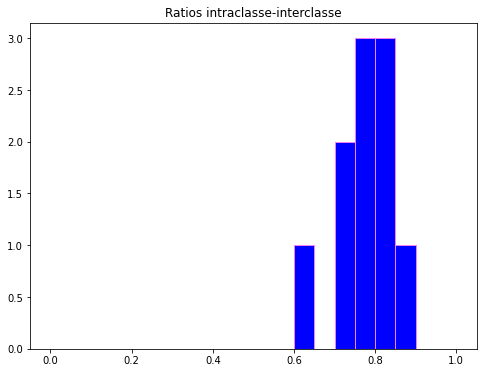

In [10]:
#Distances intraclasse et interclasse
intraclasse = []
interclasse_glob = []
for i in range(len(classes)):
  intraclasse.append(np.mean(cdist(X[y==i],X[y==i])))
  interclasse_glob.append(np.mean(cdist(X[y==i],X[y!=i])))

ratio_intra_inter = np.divide(intraclasse,interclasse_glob)

plt.figure(figsize=(8,6))
plt.hist(ratio_intra_inter,ec='violet',fc='blue',range=(0,1),bins=20)
plt.title('Ratios intraclasse-interclasse')
plt.show()

##Visualisation des données

In [11]:
##Analyse en composantes principales
ACP = PCA()
Z = ACP.fit_transform(X)
print(Z.shape)

#IDE python
"""fig2d = px.scatter(Z, x=0, y=1,   color=dataset_numpy[:,-1] )
plot(fig2d) #pour IDE python
fig3d = px.scatter_3d(Z, x=0, y=1, z=2,  color=dataset_numpy[:,-1])
fig3d.update_traces(marker_size = 2)

plot(fig3d) #pour IDE python"""
 
#Notebook
fig2d2 = go.Figure(data = [go.Scatter(x=Z[:,0], #Pour
                                      y=Z[:,1],
                                      mode='markers',
                                      marker=dict(
                                      color=y),
                                      text= dataset_numpy[:,-1]
                                      )])
fig2d2.show()

fig3d2 = go.Figure(data = [go.Scatter3d(x=Z[:,0], #Pour
                                      y=Z[:,1],
                                      z=Z[:,2],
                                      mode='markers',
                                      marker=dict(
                                      color=y,
                                      size = 1.5),
                                      text= dataset_numpy[:,-1]
                                      )])
fig3d2.show()

(1520, 12)


## Entrainement avec optimisation des hyperparamètres par GridSearch

La fonction suivante permet d'entrainer les différents modèles parmi la liste suivantes et d'evaluer leur performances sur le jeu de test: 

- Analyse discriminante Quadratique (classe *QuadraticDiscriminantAnalysis*)
- Analyse discriminante linéaire (classe *LinearDiscriminantAnalysis*)
- Modèle Gaussien Naïf Bayésien (classe *GaussianNB*)
- Un classifieur de type Nearest centroid (classe *NearestCentroid*)
- Classifieur de type Regression Logistique (classe *LogisticRegression*) 
- Classifieur de type K-ppv (classe *KNeighborsClassifier*)
- Classifieur de type MaultiLayerPerceptron (classe *MLPClassifier*) 
- Classifieur SVM (classe *SVC*)
- Classifieur de type forêt aléatoire (classe *RandomForestClassifier*)

Pour chacun de ces modèle nous avons déterminer l'ensemble des paramètres à optimiser. Nous optimisons ces hyperparamètres grace à la classe sklearn *GridSearch*.

## Split des données en jeu d'entrainement et de test

In [12]:
#Jeux de tests et d'entraînement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(f"Taille des données d'entrainement:  {len(y_train)}")
print(f"Taille des données de test:  {len(y_test)}")

Taille des données d'entrainement:  1216
Taille des données de test:  304


In [13]:
def train_and_test(clf, X_train, y_train, X_test, y_test, parameters=None):
  if parameters:
    cv = GridSearchCV(clf, parameters, cv = 3, verbose = 4, n_jobs = -1)
    cv.fit(X_train,y_train)
    y_test_pred = cv.best_estimator_.predict(X_test)
  else:
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
  return {"report" : classification_report(y_test, y_test_pred, output_dict=True),
          "confusion_matrix" : confusion_matrix(y_test, y_test_pred),
          "best_params" : cv.best_params_ if parameters else None}

In [14]:
clfs = [(QuadraticDiscriminantAnalysis(),{}),
        (LinearDiscriminantAnalysis(), {"solver" : ['svd', 'lsqr']} ),
        (GaussianNB(), {}),
        (NearestCentroid(),{"metric": ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan', 'nan_euclidean']}), 
        (LogisticRegression(),{"solver" : ['newton-cg', 'lbfgs', 'sag', 'saga']} ), 
        (KNeighborsClassifier(),{"n_neighbors" : np.arange(1, 100, 10)} ), 
        (MLPClassifier(),{"batch_size" : [4,8,16,64,128], "hidden_layer_sizes" : [300, 500, 1000]}),
        (SVC(), {"C" : np.logspace(-3,3,7), "kernel" : ["linear", "rbf", "poly", "sigmoid"]}),
        (RandomForestClassifier(), {"n_estimators": [10, 50, 100], "criterion" : ["gini", "entropy", "log_loss"]})
        ]

all_results  = {clf.__class__.__name__ : train_and_test(clf, X_train, y_train, X_test, y_test, parameters) for clf, parameters in clfs}

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_nearest_centroid.py:164: UserWarning:

Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Fitting 3 folds for each of 28 candidates, totalling 84 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


9 fits failed out of a total of 27.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", li

In [ ]:
pretty(all_results)

QuadraticDiscriminantAnalysis
	report
		0
			precision
				0.14285714285714285
			recall
				0.08695652173913043
			f1-score
				0.1081081081081081
			support
				23
		1
			precision
				0.8157894736842105
			recall
				0.8611111111111112
			f1-score
				0.8378378378378377
			support
				36
		2
			precision
				0.3787878787878788
			recall
				0.8064516129032258
			f1-score
				0.5154639175257731
			support
				31
		3
			precision
				0.75
			recall
				0.6666666666666666
			f1-score
				0.7058823529411765
			support
				27
		4
			precision
				0.5094339622641509
			recall
				0.8181818181818182
			f1-score
				0.627906976744186
			support
				33
		5
			precision
				0.6666666666666666
			recall
				0.5405405405405406
			f1-score
				0.5970149253731343
			support
				37
		6
			precision
				0.68
			recall
				0.5483870967741935
			f1-score
				0.6071428571428571
			support
				31
		7
			precision
				0.3125
			recall
				0.1724137931034483
			f1-score
				0.22222222222222224
			support

In [15]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

with open("./drive/MyDrive/data/all_result.json", "w") as f:
  json.dump(all_results, f, indent = 4, cls = NpEncoder)
  f.close()

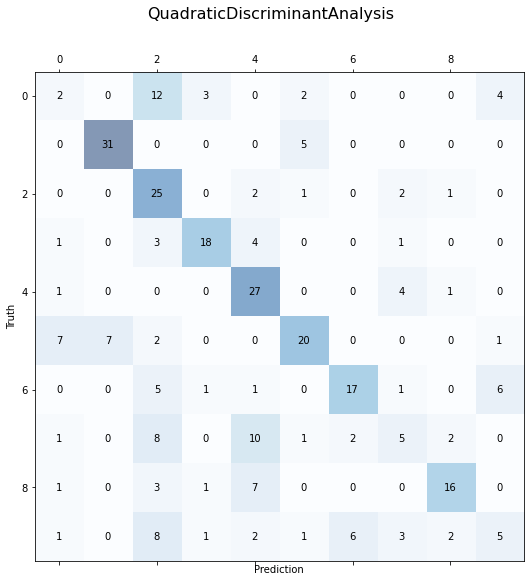

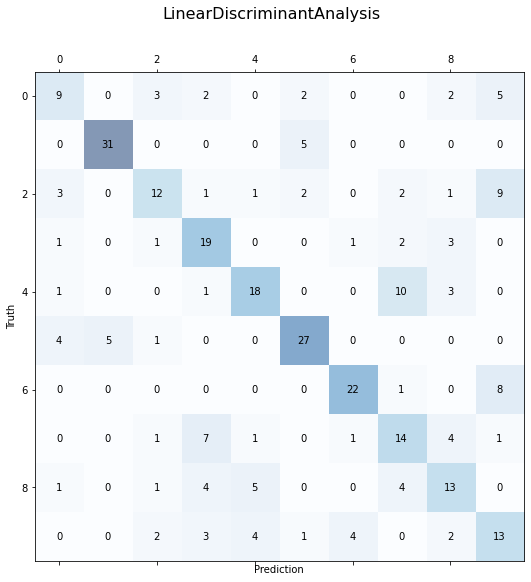

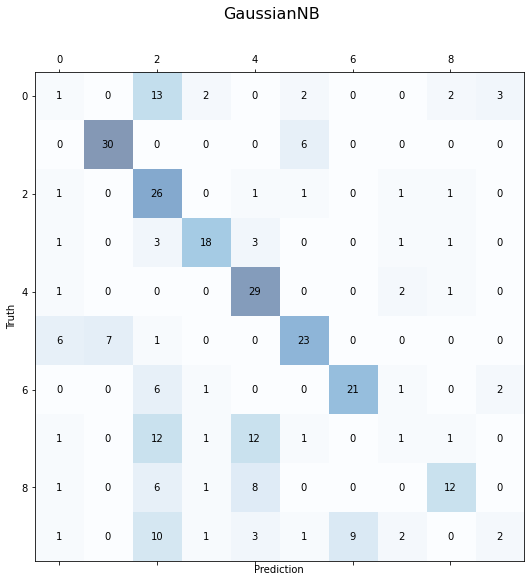

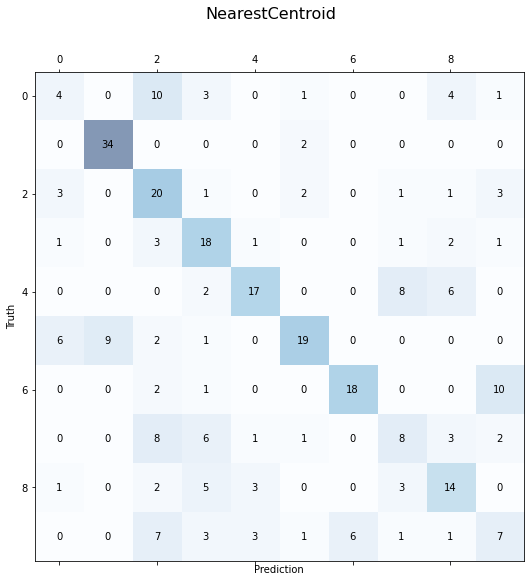

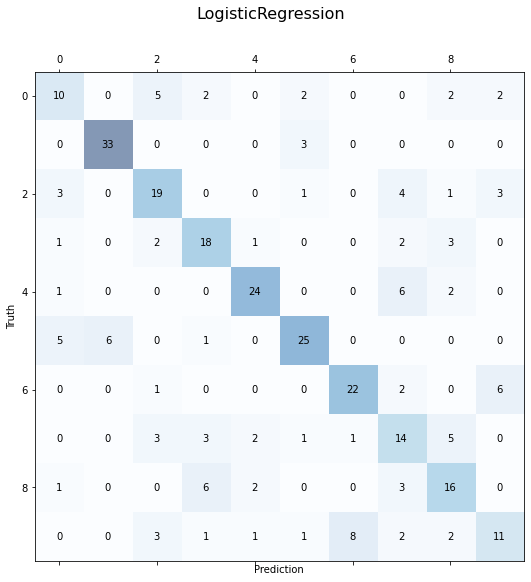

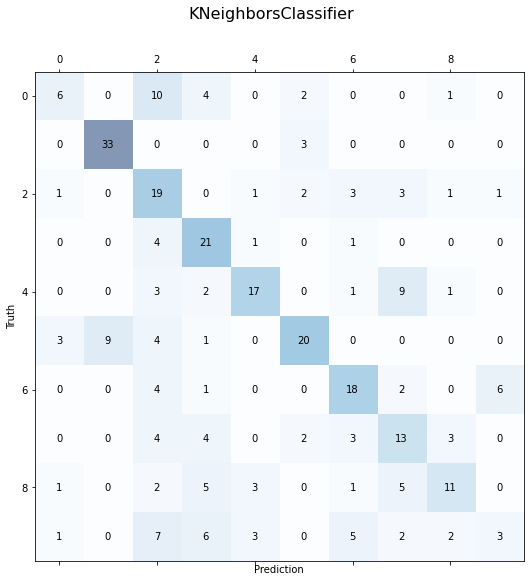

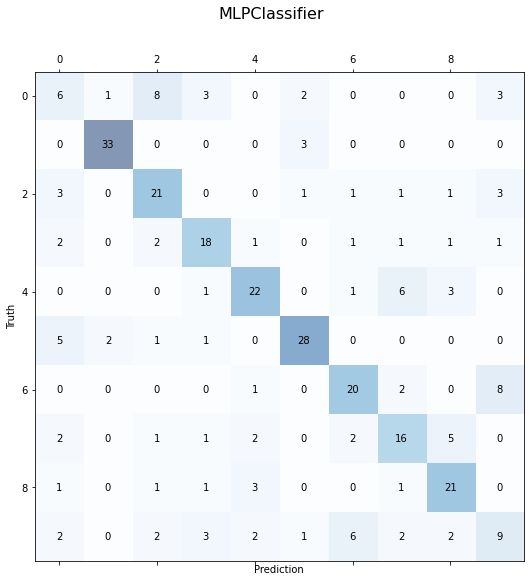

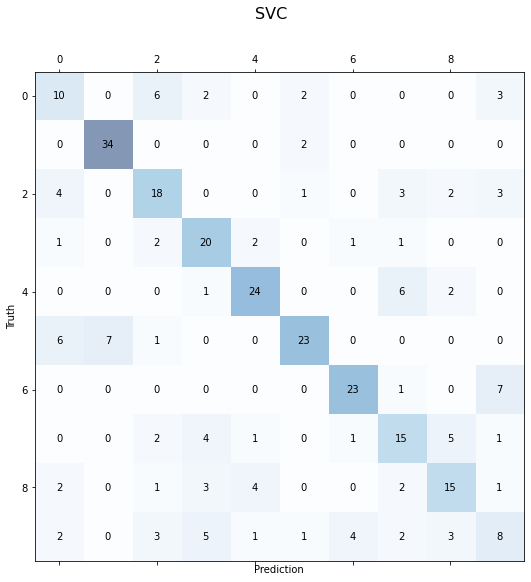

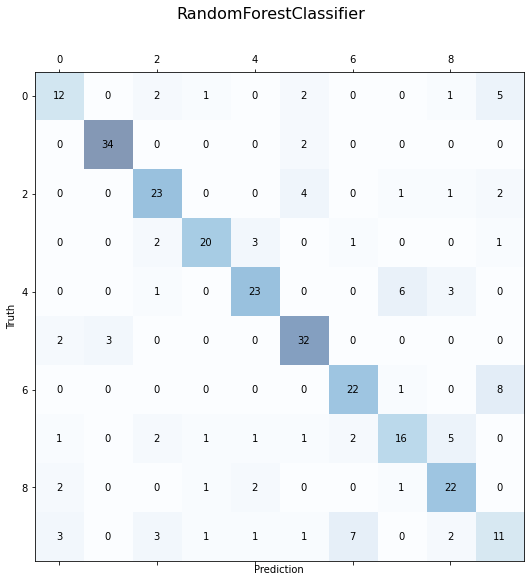

In [16]:
for clf in all_results:
  confmat = all_results[clf]["confusion_matrix"]
  fig, ax = plt.subplots(figsize=(9, 9))
  ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
  fig.suptitle(clf, fontsize=16)
  for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
      ax.text(x=j, y=i, s=confmat[i, j], va="center", ha="center")
      plt.xlabel("Prediction");
      plt.ylabel("Truth")


## Entrainement avec choix des hyperparamètres selon l'entrainement précédent.

In [17]:
def get_all_classifiers_with_optim_parameters():
  with open("./drive/MyDrive/data/all_result.json", "r") as f:
    all_results = json.load(f)
  return [eval(clf)(**all_results[clf]["best_params"]) if all_results[clf]["best_params"] else eval(clf)() for clf in all_results]

all_clfs = get_all_classifiers_with_optim_parameters()
print(all_clfs)

[QuadraticDiscriminantAnalysis(), LinearDiscriminantAnalysis(), GaussianNB(), NearestCentroid(metric='cityblock'), LogisticRegression(solver='newton-cg'), KNeighborsClassifier(n_neighbors=21), MLPClassifier(batch_size=64, hidden_layer_sizes=300), SVC(kernel='linear'), RandomForestClassifier(criterion='entropy')]


In [ ]:
all_results = {}
for clf in all_clfs: 
  all_results[clf.__class__.__name__] = train_and_test(clf, X_train, y_train, X_test, y_test, parameters = None)

pretty(all_results)

NameError: ignored

In [46]:
#%%Réseau de neurones
y1 = tf.keras.utils.to_categorical(y)
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state = 42, shuffle=True)
input_layer= Input(X_train.shape[1])
x = Flatten()(input_layer)
x = Dense (200, activation = 'tanh')(x)
x = Dense (200, activation = 'tanh')(x)




output_layer = Dense (10 ,activation = 'softmax')(x)
model = Model(input_layer, output_layer)

#model.summary()

opt= Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(X1_train, y1_train,batch_size=32, epochs = 200,validation_data=(X1_test, y1_test),verbose=2)

Epoch 1/200
38/38 - 1s - loss: 1.6226 - accuracy: 0.4211 - val_loss: 1.3330 - val_accuracy: 0.5362 - 805ms/epoch - 21ms/step
Epoch 2/200
38/38 - 0s - loss: 1.1744 - accuracy: 0.5929 - val_loss: 1.2043 - val_accuracy: 0.5461 - 149ms/epoch - 4ms/step
Epoch 3/200
38/38 - 0s - loss: 1.0646 - accuracy: 0.6250 - val_loss: 1.1545 - val_accuracy: 0.5987 - 134ms/epoch - 4ms/step
Epoch 4/200
38/38 - 0s - loss: 1.0167 - accuracy: 0.6373 - val_loss: 1.1138 - val_accuracy: 0.6086 - 242ms/epoch - 6ms/step
Epoch 5/200
38/38 - 0s - loss: 0.9878 - accuracy: 0.6398 - val_loss: 1.0857 - val_accuracy: 0.6316 - 243ms/epoch - 6ms/step
Epoch 6/200
38/38 - 0s - loss: 0.9640 - accuracy: 0.6513 - val_loss: 1.0798 - val_accuracy: 0.6118 - 241ms/epoch - 6ms/step
Epoch 7/200
38/38 - 0s - loss: 0.9529 - accuracy: 0.6488 - val_loss: 1.0818 - val_accuracy: 0.6184 - 187ms/epoch - 5ms/step
Epoch 8/200
38/38 - 0s - loss: 0.9421 - accuracy: 0.6530 - val_loss: 1.0690 - val_accuracy: 0.6447 - 195ms/epoch - 5ms/step
Epoch 9

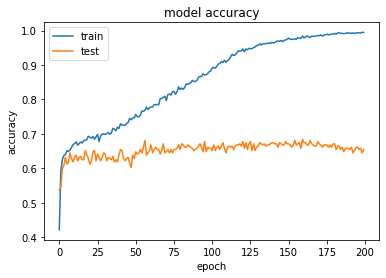

In [47]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()